In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from mlelec.data.dataset import (
    precomputed_molecules,
    MoleculeDataset,
    MLDataset,
    get_dataloader,
)
import torch
from ase.io import read
import ase
from mlelec.models.linear import LinearTargetModel
from mlelec.features.acdc import compute_features_for_target

import matplotlib.pyplot as plt
from IPython.utils import io

In [3]:
water_data = MoleculeDataset(
    mol_name="water_1000",  # Uses precomputed data by this name 
    frame_slice=slice(0, 100), # Loads 100 frames 
    device="cuda",
    aux=["overlap", "orbitals"],
    target=["fock"],
)
ml_data = MLDataset(
    molecule_data=water_data,
    device="cuda",
    model_strategy="coupled", # We will be building models for coupled blocks 
    shuffle=True,
    shuffle_seed=5380,
)  

ml_data._split_indices(train_frac=0.7, val_frac=0.2, test_frac=0.1)
# Only models based on features = 'acdc' supported for now

hypers = {
            "cutoff": 4.0,
            "max_radial": 5,
            "max_angular": 3,
            "atomic_gaussian_width": 0.3,
            "center_atom_weight": 1,
            "radial_basis": {"Gto": {}},
            "cutoff_function": {"ShiftedCosine": {"width": 0.1}},
        }


if ml_data.features is None:
    # ml_data._set_features(compute_features_for_target(ml_data, device="cuda"))
    # one can pass hypers here as follows otherwise default hypers are used
    ml_data._set_features(compute_features_for_target(ml_data, device = "cuda", hypers = hypers)) # one can pass hypers here 

train_dl, val_dl, test_dl = get_dataloader(ml_data, model_return="tensor") # instantiate dataloaders

Loading structures
examples/data/water_1000/sto-3g/fock.hickle


/home/nigam/miniconda3/envs/mlelec/lib/python3.11/site-packages/rascaline/systems/ase.py:57: UserWarning: periodic boundary conditions are disabled, but the cell matrix is not zero, we will set the cell to zero.
  warnings.warn(


## 1. Learn Hamiltonian, then predict other properties 

In [4]:
model = LinearTargetModel(
    dataset=ml_data, nlayers=1, nhidden=16, bias=False, device="cuda"
)

In [5]:
from cmath import inf

best = inf
early_stop_criteria = 50

In [6]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, factor=0.5, patience=10, verbose=True
)
import mlelec.metrics as mlmetrics

val_interval = 10
loss_fn = getattr(mlmetrics, "L2_loss")
losses = []
early_stop_count = 0
nepochs = 800

In [7]:
for epoch in range(nepochs):
    model.train(True)
    train_loss = 0
    for i, data in enumerate(train_dl):
        optimizer.zero_grad()
        pred = model(data["input"], return_type="tensor", batch_indices=data["idx"])  
        loss = loss_fn(pred, data["output"])
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
    losses.append(train_loss)
    # scheduler.step(train_loss)
    model.train(False)

    if epoch % val_interval == 0:
        val_loss = 0
        for i, data in enumerate(val_dl):
            pred = model(data["input"], return_type="tensor", batch_indices=data["idx"])
            vloss = loss_fn(pred, data["output"])
            val_loss += vloss.item()
        new_best = val_loss < best
        if new_best:
            best = val_loss
            torch.save(model.state_dict(), "best_model.pt")
            early_stop_count = 0
        else:
            early_stop_count += 1
        if early_stop_count > early_stop_criteria:
            print(f"Early stopping at epoch {epoch}")
            print(f"Epoch {epoch}, train loss {train_loss/len(ml_data.train_idx)}")

            print(f"Epoch {epoch} val loss {val_loss/len(ml_data.val_idx)}")
            # Save last best model
            break

        # val_loss = loss_fn(torch.cat(val_pred), torch.cat(val))
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, train loss {train_loss/len(ml_data.train_idx)}")

        print(f"Epoch {epoch} val loss {val_loss/len(ml_data.val_idx)}")

Epoch 0, train loss 473.79416576282904
Epoch 0 val loss 464.7616585233897
Epoch 10, train loss 165.01286791888657
Epoch 10 val loss 145.22437187062243
Epoch 20, train loss 9.677403403718946
Epoch 20 val loss 7.758534992925731
Epoch 30, train loss 4.0993923972463575
Epoch 30 val loss 4.375993381387507
Epoch 40, train loss 3.249317222831573
Epoch 40 val loss 3.320521304292547


KeyboardInterrupt: 

Text(0, 0.5, 'MSE \\ a.u.')

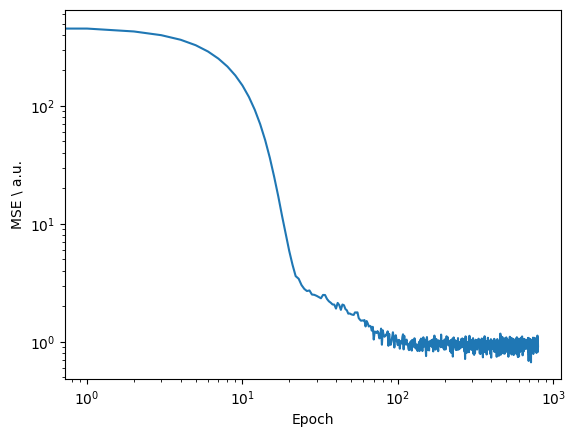

In [ ]:
import numpy as np

plt.loglog(np.asarray(losses) / len(ml_data.train_idx))
plt.xlabel("Epoch")
plt.ylabel("MSE \ a.u.")

### Input model prediction into pyscf to compute dipole moment 

In [ ]:
import os

os.environ["PYSCFAD_BACKEND"] = "torch"

import torch
from pyscf import gto

from pyscfad import numpy as pynp
from pyscfad import ops
from pyscfad.ml.scf import hf
import pyscf.pbc.tools.pyscf_ase as pyscf_ase

In [ ]:
from mlelec.data.pyscf_calculator import _instantiate_pyscf_mol
from mlelec.utils.twocenter_utils import fix_orbital_order, unfix_orbital_order
import mlelec.metrics as mlmetrics

In [ ]:
def compute_dipole_moment(frames, fock_predictions, overlaps):
    assert (
        len(frames) == len(fock_predictions) == len(overlaps)
    ), "Length of frames, fock_predictions, and overlaps must be the same"
    dipoles = []
    for i, frame in enumerate(frames):
        mol = _instantiate_pyscf_mol(frame)
        mf = hf.SCF(mol)
        fock = torch.autograd.Variable(
            fock_predictions[i].type(torch.float64), requires_grad=True
        )

        mo_energy, mo_coeff = mf.eig(fock, overlaps[i])
        mo_occ = mf.get_occ(mo_energy)  # get_occ returns a numpy array
        mo_occ = ops.convert_to_tensor(mo_occ)
        dm1 = mf.make_rdm1(mo_coeff, mo_occ)
        dip = mf.dip_moment(dm=dm1)
        dipoles.append(dip)
    return torch.stack(dipoles)

In [ ]:
# TEST set

# with HiddenPrints():
with io.capture_output() as captured:
    fock_predictions = model.forward(ml_data.feat_test, return_type="tensor")
    # convert prediction back to pyscf order
    fock_predictions = unfix_orbital_order(
        fock_predictions,
        ml_data.test_frames,
        ml_data.molecule_data.aux_data["orbitals"],
    )

    dipole_predictions = compute_dipole_moment(
        ml_data.test_frames,
        fock_predictions,
        ml_data.molecule_data.aux_data["overlap"][ml_data.test_idx],
    )
    # very imp to pass the right overlap matrix


error = mlmetrics.L2_loss(
    dipole_predictions, ml_data.molecule_data.target["dipole_moment"][ml_data.test_idx]
)
print("(TEST) MSE on dipole", error / len(dipole_predictions))

(TEST) MSE on dipole tensor(0.3787, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


In [ ]:
# Entire dataset
with io.capture_output() as captured:
    fock_predictions = model.forward(ml_data.features, return_type="tensor")
    # convert prediction back to pyscf order
    fock_predictions = unfix_orbital_order(
        fock_predictions, ml_data.structures, ml_data.molecule_data.aux_data["orbitals"]
    )
    dipole_predictions = compute_dipole_moment(
        ml_data.structures, fock_predictions, ml_data.molecule_data.aux_data["overlap"]
    )
error = mlmetrics.L2_loss(
    dipole_predictions, ml_data.molecule_data.target["dipole_moment"]
)
print("MSE on dipole", error / len(dipole_predictions))

MSE on dipole tensor(0.2696, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


### test equivariance of prediction/features 

In [ ]:
import hickle

rotations = hickle.load("examples/data/water_rotated/rotations.hickle")
#check equivairance of predicted blocks
# r1 = model.forward(ml_data.features, return_type="coupled_blocks")
# check equivar of features 
r1 = ml_data.features

In [ ]:
from mlelec.utils.metatensor_utils import labels_where
from mlelec.utils.symmetry import _wigner_d_real
import numpy as np
from metatensor import Labels

for i, (k, b) in enumerate(r1.items()):
    unrot_idx = labels_where(
        b.samples,
        selection=Labels(["structure"], values=np.asarray([[0]]).reshape(-1, 1)),
        return_idx=True,
    )[-1]
    rot_idx = labels_where(
        b.samples,
        selection=Labels(
            ["structure"], values=np.asarray([[ml_data.test_idx]]).reshape(-1, 1)
        ),
        return_idx=True,
    )[-1]
    # L = k['L'] # use when testing blocks 
    L = k["spherical_harmonics_l"] # use when testing features 
    wd = _wigner_d_real(L, *rotations[ml_data.test_idx - 1]).to(b.values)
    if torch.linalg.norm(wd @ b.values[unrot_idx] - b.values[rot_idx]) > 1e-7:
        print(torch.linalg.norm(wd @ b.values[unrot_idx] - b.values[rot_idx]))

## Calculate the target dipole moment of water molecule in case data not found

In [ ]:

from mlelec.data.pyscf_calculator import calculator

calc = calculator(
    path="examples/data/water_1000/",
    mol_name="water_1000",
    frame_slice=":",
    target=["fock", "dipole_moment", "density"],
)
calc.calculate(basis_set="sto-3g", verbose=1)
calc.save_results()#(path="examples/data/water_1000/sto-3g/")